# Classifying Tweet Emotions

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import re

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

# Import NLP modules
from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_colwidth', 160)

## Understanding Data

In [2]:
df = pd.read_csv('data/text_emotion.csv')

In [3]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
df.describe(include='all')

,tweet_id,sentiment,author,content
count,4.000000e+04,40000,40000,40000
unique,NaN,13,33871,39827
top,NaN,neutral,MissxMarisa,I just received a mothers day card from my lov...
freq,NaN,8638,23,14
mean,1.845184e+09,NaN,NaN,NaN
std,1.188579e+08,NaN,NaN,NaN
min,1.693956e+09,NaN,NaN,NaN
25%,1.751431e+09,NaN,NaN,NaN
50%,1.855443e+09,NaN,NaN,NaN
75%,1.962781e+09,NaN,NaN,NaN


In [6]:
# Print the number of unique values of tweet_id
df.tweet_id.nunique()

40000

Tweet id is unique as expected. It seems that some authors tweeted multiple times. 

`sentiment` is the label. There are 13 emotions in this column.

Some values in the `content` column appear more than once. There are **same** tweets for some oft the `tweet_id`s.

## Data Preparation

### Univariate Analysis - Investigating Variables

#### Sentiment

In [68]:
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8579.0,0.214905
worry,8455.0,0.211799
happiness,5208.0,0.130461
sadness,5162.0,0.129309
love,3841.0,0.096217
surprise,2187.0,0.054785
fun,1776.0,0.044489
relief,1526.0,0.038226
hate,1323.0,0.033141
empty,815.0,0.020416


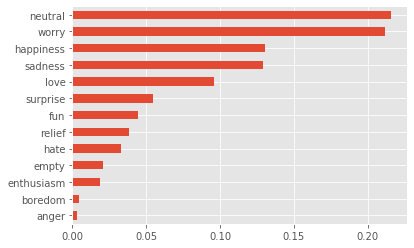

In [38]:
plt.style.use('ggplot')

df.sentiment.value_counts(normalize=True).sort_values(ascending=True).plot.barh()

#### Author

In [39]:
df.author.value_counts()

MissxMarisa       23
ChineseLearn      22
MiDesfileNegro    19
erkagarcia        19
lost_dog          18
                  ..
NatPivac77         1
energizerame       1
Lijaaa             1
camillawalker      1
KlaBrost           1
Name: author, Length: 33871, dtype: int64

In [51]:
df[df.author=='MissxMarisa']

,tweet_id,sentiment,author,content
260,1957023061,surprise,MissxMarisa,@freshypanda Im sorry I don't think I stick o...
333,1957041812,hate,MissxMarisa,"@meganmansyn Hahahaha! It's not horrible, if o..."
1941,1957434995,neutral,MissxMarisa,@tsarnick This year
2143,1957479923,worry,MissxMarisa,@Zobi09 I'm concerned for that family
2298,1957514298,neutral,MissxMarisa,"@tsarnick Yeah, that was my thumb last night. ..."
21267,1694202109,love,MissxMarisa,@shortyyyy Thank you I liked Joe's clothes' b...
21560,1694256899,surprise,MissxMarisa,@Zanna85 Bill can take me to Fangtasia and hit...
22574,1694455792,happiness,MissxMarisa,@Zobi09 The cast of True Blood was there
22773,1694493269,sadness,MissxMarisa,"@Zobi09 Haha yes I do it's hard work, too! I ..."
23154,1694568031,neutral,MissxMarisa,@TheLonely California


#### Content

In [46]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9                     14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                                      13
Happy Mothers Day                                                                                                                10
Happy Mother's Day!                                                                                                              10
happy mother's day                                                                                                                8
                                                                                                                                 ..
@andyclemmensen have you seen the game on the website?! awesomness!!! go on msn                                                   2
@thecompletes seen u a couple of times. Liked it                            

Some tweets are tweeted multiple times by different users. These may also be Retweets. There is not any information about RTs in the dataset.

In [50]:
df[df.content=='I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9']

,tweet_id,sentiment,author,content
33496,1752619550,love,unifiedclock,I just received a mothers day card from my lov...
33693,1752674435,love,TheOrakill,I just received a mothers day card from my lov...
33874,1752725133,worry,charlesstinger,I just received a mothers day card from my lov...
34071,1752774341,love,jamesbankso,I just received a mothers day card from my lov...
34298,1752824798,love,sarahmarche,I just received a mothers day card from my lov...
34480,1752873814,love,xmanoxx,I just received a mothers day card from my lov...
34672,1752920582,love,oblongshmoblong,I just received a mothers day card from my lov...
34861,1752965288,love,lilpiggynose,I just received a mothers day card from my lov...
35051,1753009856,love,unitedstatesfre,I just received a mothers day card from my lov...
35232,1753052362,love,unifiedclock,I just received a mothers day card from my lov...


Interestingly, for the same tweet there are different sentiments in the label column. There may be more false labels in the dataset!

### Further Anaylsis

#### Mentions

In [14]:
# Tweets that contain "mentions"
df.content.str.contains("@\w+")

0         True
1        False
2        False
3        False
4         True
         ...  
39995     True
39996    False
39997    False
39998     True
39999     True
Name: content, Length: 40000, dtype: bool

In [18]:
df.content.str.contains("@\w+").mean()

0.473925

Almost half of the tweets contain mentions. This does not seem normal. Let's see the distribution of emotions through mentioned tweets.

In [25]:
df.groupby('sentiment').content.apply(lambda x: x.str.contains("@\w+").mean()).sort_values()

sentiment
boredom       0.273743
hate          0.375661
sadness       0.400000
anger         0.427273
worry         0.433266
relief        0.441678
empty         0.488513
happiness     0.491265
love          0.504425
enthusiasm    0.508564
neutral       0.526395
surprise      0.527663
fun           0.546734
Name: content, dtype: float64

People possibly tend to mention others more when they have positive sentiment. Let's investigate this result further.

In [3]:
# Create a sentiment dictionary to map EMOTIONS to SENTIMENTS.
sentiment_dict = {'boredom': 'negative',
                  'hate': 'negative',
                  'sadness': 'negative',
                  'anger': 'negative',
                  'worry': 'negative',
                  'relief': 'positive',
                  'empty': 'neutral',
                  'happiness': 'positive',
                  'love': 'positive',
                  'enthusiasm': 'positive',
                  'neutral': 'neutral',
                  'surprise':'positive',
                  'fun': 'positive'
                 }
df['polarity'] = df.sentiment.map(sentiment_dict)

#### UPDATE FEATURE ENGINEERING

In [34]:
# Mentions by sentiment_new
df.groupby('polarity').content.apply(lambda x: x.str.contains("@\w+").mean()).sort_values()

polarity
negative    0.415070
positive    0.502124
neutral     0.523085
Name: content, dtype: float64

#### Hashtags

In [23]:
# Tweets that contain "hashtags"
df.content.str.contains("#\w+").mean()

0.01975

Only a small portion of tweets contain `#` (hashtag) s

#### Polarity

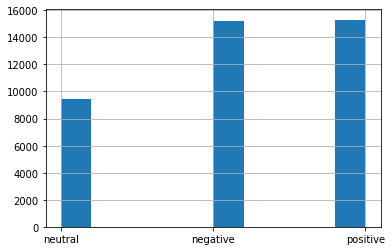

In [31]:
df.polarity.hist()

The frequencies of _sentiments_ appear to be more balanced when compared to that of the _emotions_.

#### Number of Characters

In [39]:
# Describe the length of the tweets in the contents column.
df.content.str.len().describe()

count    40000.000000
mean        73.405550
std         36.558015
min          1.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: content, dtype: float64

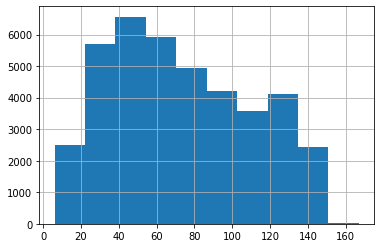

In [119]:
# Plot a histogram of the number of characters in tweets
df.content.str.len().hist()

Twitter has recently change the _character limit_ from 140 to 280. The dataset is possibly created before the change. However, some tweets contain more than 140 characters. I initially suspected that these are the ones with links. Yet the reason seems to be 'special entities' such as `&quot;` or "`&amp;` which are rendered as -&quot;- and -&amp;- respectively. [Special Entities](http://www.htmlhelp.com/reference/html40/entities/special.html)

It is worth noting that most of the tweets contans less than 80 characters. It may be extremely hard to detect sentiments from such a text.

In [49]:
df[df.content.str.len()>140].sample(10)

,tweet_id,sentiment,author,content,polarity
6657,1961410317,sadness,loew01,"wow, I didn't realized that there is a limit to the &quot;more&quot; button. That sucks... I guess two days is the max to not sign in to twitter. !",negative
12498,1963588292,love,Chriztophe,"met a cute girl at mighty taco.I'm ordering(no cheese, no sour cream, etc)&amp; she's like&quot;it's ok, I'm Vegan too!&quot;(insert hot wink)too young",positive
36840,1753382411,love,love_yazmo,you know you love your mom when you stay up this late just to wrap her gifts (which look glorious) &amp; hand-make a card.. happy mothers day,positive
20857,1694126085,neutral,byhuy,@ducban &quot;nhi?p ?nh gia&quot; ? ?ï¿½y lï¿½ ch? cï¿½c b?n t? x?ng lï¿½ &quot;?am mï¿½ nhi?p ?nh&quot;. Cï¿½n ng??i thï¿½ch ch?p ?nh thï¿½ 99% dï¿½n s? r?i,neutral
26385,1695376835,neutral,geminimag,TalkingWithTami morning Ms. Tammie! Your fam looked adorable in Family Circle I bought it &amp; was like &quot;see honey? I talked to her&quot; LOL,neutral
12841,1963743820,neutral,ETown_Lesley,4am Hubby's alarm-song playing was &quot;Blame it on the Alcohol&quot; Of course I couldn't get back to sleep after cause thinking of Joe on cruise,neutral
11587,1963282166,happiness,RandyAmberTK,@mileycyrus they closed the voting...all u can vote for now is best movie Hope you win it! My 4 y/o Daughter lovesss 2 sing &quot;The Climb&quot;,positive
24773,1694928700,sadness,coffeegeek,Illy's note in the book: &quot;From one 'geek' to another - keep up the good work!&quot; sigh. He is missed - and he was great for espresso.,negative
30761,1751714638,neutral,BrandyLionWine,"@stuartdavis C'mon, we're talking about philos-ophy - the love of wisdom. I need a &quot;mat&quot; - a context to intersubjectively &quot;ground&quot; it.",neutral
32304,1752256387,neutral,TimeOutMom,@MyPreciousKid - i can do &quot;Nana&quot; or &quot;Nana Rocks&quot; for you in rhinestones &amp; do printed onesies for them &quot;my nana loves me&quot;,neutral


In [12]:
# Print tweets with less than 5 characters
df[df.content.str.len()<5]

,tweet_id,sentiment,author,content,polarity
340,1957042734,empty,Kayleia,0,neutral
15028,1964712204,neutral,KimberlyBarrena,0,neutral
29869,1751394197,neutral,JaBrezzy96,0,neutral
39415,1753819910,neutral,superbot5000,0,neutral


There are tweets which contains only a single character. These should be removed. 

In [4]:
# Drop unnecessary rows
df.drop(df[df.content.str.len()<5].index, inplace=True)

In [5]:
df.shape

(39996, 5)

In [38]:
# Print tweets with less than 10 characters
df[df.content.str.len()<10].sample(5)

,tweet_id,sentiment,author,content,polarity,language
5473,1960864881,neutral,brianisawesome,@aigulf,neutral,et
6718,1961422696,sadness,jimifan212,headache,negative,en
20095,1693976364,neutral,slappinmybass,seepin'.,neutral,fi
15849,1965010120,worry,katezoe,MAYDAY?!,negative,so
5961,1961103207,neutral,MsRudie,Its cold,neutral,en


Some tweets consist of only mentions. We may need to drop them as well.

In [58]:
# Detect the tweets that contains only mentions
df[df.content.str.replace("@\w+", "").str.len()<2].head()

,tweet_id,sentiment,author,content,polarity
659,1957119180,neutral,mallycakes,@Joshuah_Pearson,neutral
664,1957120767,neutral,joelmagic,@emlevins,neutral
3181,1957722271,neutral,Samantha_Mayy,@Clumsyflic,neutral
4865,1960537578,neutral,edduleroy,@philleasfogg,neutral
4933,1960562456,neutral,rickoshea,@WillKnott,neutral


In [59]:
# # Drop the tweets that contains only mentions
# df.drop(df[df.content.str.replace("@\w+", "").str.len()<2].index, inplace=True)

#### UPDATE FEATURE ENGINEERING

In [60]:
df.shape

(39920, 5)

#### Detect Language

##### TextBlob

In [16]:
# from textblob import TextBlob
# # b = TextBlob("merhaba")
# # b.detect_language()

# from time import sleep

# def detect_lan(tweet):

#     sleep(.01)
#     try:
#         return TextBlob(tweet).detect_language()
#     except:
#         return np.nan

# df['language'] = df.content.apply(detect_lan)

In [69]:
# df['language'] = df.content.apply(lambda tweet: TextBlob(tweet).detect_language())

##### langdetect

In [123]:
from langdetect import detect
df['language'] = df.content.apply(lambda tweet: detect(tweet))

In [19]:
# Print detected languages
df['language'].value_counts()

en    37129
af      392
so      359
cy      231
nl      213
tl      196
no      157
et      131
id      124
de      117
fr      109
ca      100
it       94
da       77
fi       75
sv       74
ro       54
pl       47
hr       46
sw       45
sq       36
es       35
pt       34
tr       33
vi       30
sl       17
sk       17
cs       12
hu        9
lt        1
uk        1
lv        1
Name: language, dtype: int64

In [122]:
df[df['language']!='en'].sample(10)

KeyError: 'language'

It seems that most of the tweets that are detected as non-English have mistakes in the words, such as missing a letter or having extra characters, or they have mentions. Let's see the results w/o mentions.

In [115]:
def detect_language(tweet):
    try:
        return detect(tweet)
    except:
        return "unknown"

In [63]:
# Detect language of tweets without mentions
df['language'] = df.content.str.replace("@\w+", "").apply(detect_language)

In [64]:
df['language'].value_counts()

en         36713
so           482
af           460
cy           235
tl           212
nl           196
no           163
fr           145
de           120
et           118
id           107
ca           102
it           102
da            86
sv            77
fi            69
pl            66
tr            58
hr            56
ro            47
sw            47
pt            45
vi            41
es            39
sq            33
cs            25
sk            24
sl            20
unknown       18
hu             6
lt             5
lv             3
Name: language, dtype: int64

The number of "en"s is decreased. We may need to perform tokenization and preprocessing in order to get legit results from text detection.

Whether these tweets are really non-English or incorrect sentence/word structure, they may be dropped for the quality of the analysis.

> NEEDS FURTHER INVESTIGATION

##### FastText (by Facebook)

In [24]:
#!pip install fasttext

# Model link: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

In [28]:
import fasttext

language_model = fasttext.load_model('data/lid.176.bin')

def detect_fasttext(tweet):
    prediction = language_model.predict(tweet)
    label = prediction[0][0].split("__label__")[1]
    return label

df['fasttext'] = df.processed.apply(detect_fasttext)

In [30]:
df.fasttext.value_counts()

en     39367
de       118
ja        88
es        81
pt        53
fr        52
nl        25
it        19
tl        15
ro        14
fi        13
zh        13
no        12
id        11
hu         9
ca         8
tr         8
cs         7
ru         7
sv         7
ms         5
et         4
pl         4
eo         4
ceb        3
ia         3
da         2
sq         2
nn         2
cy         2
uz         2
si         2
gl         2
hr         2
lb         2
la         2
vi         2
nds        2
io         1
kk         1
ast        1
el         1
ba         1
ta         1
fy         1
hy         1
az         1
jbo        1
sw         1
uk         1
kw         1
ko         1
dv         1
eu         1
gu         1
ilo        1
ga         1
qu         1
km         1
sa         1
Name: fasttext, dtype: int64

Accuracy is clearly higher with FastText language identifier.

In [35]:
df[df['fasttext'] != 'en'].content.sample(10)

553                                                         my sister is a douchebag
28251                                @chetbuchanan SANJAYA FOREVER! HAHAHAHAHAHA!!!!
11293                                                          @AMcCallon  stop itt!
32989    @Ms_GiiGgl3z lmao ight im dun wit the faces lmao id rather see urs tho  lol
15192                                @shivface oh my god im sooooooooo sick  help me
23479                                                          just made som situpps
38271                                     HAPPY MOTHER'S DAY TO MY BEAUTIFUL MOMMIES
18235                                         Im soooooooo damn hungry!! wat 2 eat??
32588                                                      @Aroundtheus  cheers!! ;)
23979                              Thx, Robban  http://www.sk-gaming.com/match/17905
Name: content, dtype: object

#### Hyperlinks

In [40]:
# Number/ratio of tweets with hyperlinks
df.content.str.lower().str.contains("http").agg([np.sum, np.mean])

sum     1811.00000
mean       0.04528
Name: content, dtype: float64

In [39]:
df[df.content.str.lower().str.contains("http")].sentiment.value_counts(normalize=True)

neutral       0.298730
worry         0.144119
happiness     0.141911
love          0.122032
sadness       0.079514
fun           0.059083
surprise      0.055218
relief        0.028713
empty         0.027057
hate          0.020983
enthusiasm    0.019326
anger         0.002209
boredom       0.001104
Name: sentiment, dtype: float64

In [108]:
df[~df.content.str.contains("http")].sentiment.value_counts(normalize=True)

worry         0.214692
neutral       0.211968
sadness       0.131491
happiness     0.129684
love          0.094828
surprise      0.054655
fun           0.043708
relief        0.038602
hate          0.033652
empty         0.020348
enthusiasm    0.018960
boredom       0.004635
anger         0.002776
Name: sentiment, dtype: float64

It seems that sharing a link may have some, though not significant relationship with the sentiment. Lets keep this as a feature, or in the text???

In [109]:
# Create a new column "has_link"
df['has_link'] = df.content.str.contains("http")*1

### Feature Engineering

In [3]:
# Create a sentiment dictionary to map EMOTIONS to SENTIMENTS.
sentiment_dict = {'boredom': 'negative',
                  'hate': 'negative',
                  'sadness': 'negative',
                  'anger': 'negative',
                  'worry': 'negative',
                  'relief': 'positive',
                  'empty': 'neutral',
                  'happiness': 'positive',
                  'love': 'positive',
                  'enthusiasm': 'positive',
                  'neutral': 'neutral',
                  'surprise':'positive',
                  'fun': 'positive'
                 }
df['polarity'] = df.sentiment.map(sentiment_dict)

In [4]:
# Drop unnecessary rows with less than 5 characters
df.drop(df[df.content.str.len()<5].index, inplace=True)

In [5]:
# Create a new column "has_link"
df['has_link'] = df.content.str.contains("http")*1

In [6]:
def process_tweet(tweet):
    
#     # To lowercase (not good for VADER)
#     tweet = tweet.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "@user"
    tweet = re.sub('@[^\s]+','@user',tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    # Remove hyperlinks ->>>> For now just replace with http
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)
    
#     # Remove tickers such as USD ($)
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # Remove hashtags (not good for VADER)
#     tweet = re.sub(r'#\w*', '', tweet)
    
#     # Remove Punctuation and split 's, 't, 've with a space for filter
#     tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    
#     # Remove words with 2 or fewer letters
#     tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

    return tweet

In [7]:
df['processed'] = df.content.apply(process_tweet)

In [8]:
import fasttext

language_model = fasttext.load_model('data/lid.176.bin')

def detect_fasttext(tweet):
    prediction = language_model.predict(tweet)
    label = prediction[0][0].split("__label__")[1]
    return label

df['language'] = df.processed.apply(detect_fasttext)

In [9]:
df.head()

,tweet_id,sentiment,author,content,polarity,has_link,processed,language
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,neutral,0,@user i know i was listenin to bad habit earlier and i started freakin at his part =[,en
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,negative,0,Layin n bed with a headache ughhhh...waitin on your call...,en
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,negative,0,Funeral ceremony...gloomy friday...,en
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,positive,0,wants to hang out with friends SOON!,en
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",neutral,0,"@user We want to trade with someone who has Houston tickets, but no one will.",en


#### Polarity with VADER

In [51]:
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Instantiate new SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer(tweet):
    '''
    Evaluates polarity of a given sentence and returns the result.
    '''
    score = analyzer.polarity_scores(tweet)['compound']
    if score > 0.05:
        polarity = "positive"
    elif score < -0.05:
        polarity = "negative"
    else:
        polarity = "neutral"
    
    return polarity
    
df['polarity_vader'] = df.processed.apply(sentiment_analyzer)

In [54]:
df[['polarity', 'polarity_vader']].head()

,polarity,polarity_vader
0,neutral,negative
1,negative,neutral
2,negative,negative
3,positive,positive
4,neutral,negative


In [55]:
(df.polarity == df.polarity_vader).mean()

0.5432793279327933

In [58]:
df[df.polarity != df.polarity_vader][['processed', 'polarity', 'polarity_vader']].sample(5)

,processed,polarity,polarity_vader
21802,Another water leak in my appartement. The good side is that I get to meet the girls previous next floors,negative,positive
28351,"And i ain't happy go lucky, its just today... The world don't feel ugly",neutral,negative
18678,@user or with any at all boo. suits and grey hair.,neutral,positive
2544,I didn't catch the Jonas Brothers Facebook Webcast... It already ended when I logged in to my Facebook account...,negative,neutral
11126,I really wanted that job,negative,neutral


The results of VADER does not seem to be very accurate, assuming that the emotions are correctly  categorized.

### Tokenization 

## Model (Emotions)

### Transforming Data - Create X and Y

In [10]:
# Create features and target
X = df.processed
y = df.sentiment

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=57)

### Vectorizing Tweets

#### `CountVectorizer`

In [11]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train) #Learn the vocabulary dictionary and return term-document matrix.
count_test = count_vectorizer.transform(X_test) # Transform documents to document-term matrix.

#### `TfidfVectorizer`

In [12]:
# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train) # Learn vocabulary and idf, return term-document matrix.
tfidf_test = tfidf_vectorizer.transform(X_test) # Transform documents to document-term matrix.

### Multinomial Naive Bayes Model

In [71]:
# Create a MulitnomialNB model
count_nb = MultinomialNB()

count_nb.fit(count_train, y_train)

# Run predict on count test data to get predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of predictions
count_nb_score = count_nb.score(count_test, y_test)

print('NaiveBayes Count Score: ', count_nb_score)
print(confusion_matrix(y_test, count_nb_pred, labels=y.unique()))

NaiveBayes Count Score:  0.23360280023335278
[[   0    0    0  235   21    0    6    0    0    4    0    0    0]
 [   0    0    0 1271  129    0  100    0    0   66    0    0    0]
 [   0    0    0  204   15    0    9    0    0   16    0    0    0]
 [   0    0    0 2263  181    0   94    0    0   90    0    0    0]
 [   0    0    0 2102  217    0  115    0    0  121    0    0    0]
 [   0    0    0  531   64    0   33    0    0   26    0    0    0]
 [   0    0    0  825   76    0  185    0    0   82    0    0    0]
 [   0    0    0  445   44    0   28    0    0   34    0    0    0]
 [   0    0    0  334   35    0   13    0    0   13    0    0    0]
 [   0    0    0 1050  120    0  133    0    0  138    0    0    0]
 [   0    0    0   40    3    0    1    0    0    1    0    0    0]
 [   0    0    0  334   51    0   34    0    0   31    0    0    0]
 [   0    0    0   29    4    0    1    0    0    2    0    0    0]]


In [72]:
# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, count_nb_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,2,0,1,29,0,0,0,4
boredom,0,0,0,0,0,1,0,1,40,0,0,0,3
empty,0,0,0,0,0,4,0,6,235,0,0,0,21
enthusiasm,0,0,0,0,0,16,0,9,204,0,0,0,15
fun,0,0,0,0,0,34,0,28,445,0,0,0,44
happiness,0,0,0,0,0,138,0,133,1050,0,0,0,120
hate,0,0,0,0,0,13,0,13,334,0,0,0,35
love,0,0,0,0,0,82,0,185,825,0,0,0,76
neutral,0,0,0,0,0,90,0,94,2263,0,0,0,181
relief,0,0,0,0,0,31,0,34,334,0,0,0,51


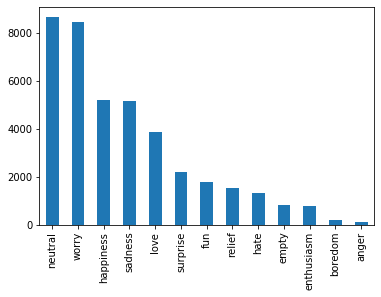

In [67]:
df.sentiment.value_counts().plot.bar()

In [73]:
# #from data.helper_functions import plot_confusion_matrix

# # Plot the confusion matrix
# plot_confusion_matrix(confusion_matrix(y_test, count_nb_pred).round(), classes=y.unique(), title="Count NB Confusion Matrix", normalize=False)

In [68]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB()

tfidf_nb.fit(tfidf_train, y_train)

# Run predict on TF-IDF test data to get predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of predictions
tfidf_nb_score = tfidf_nb.score(tfidf_test, y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)

NaiveBayes Tfidf Score:  0.23343611967663971


In [70]:
# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, tfidf_nb_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,2,0,1,29,0,0,0,4
boredom,0,0,0,0,0,1,0,1,40,0,0,0,3
empty,0,0,0,0,0,4,0,6,234,0,0,0,22
enthusiasm,0,0,0,0,0,16,0,9,203,0,0,0,16
fun,0,0,0,0,0,34,0,28,445,0,0,0,44
happiness,0,0,0,0,0,141,0,130,1050,0,0,0,120
hate,0,0,0,0,0,13,0,13,334,0,0,0,35
love,0,0,0,0,0,88,0,179,820,0,0,0,81
neutral,0,0,0,0,0,91,0,92,2263,0,0,0,182
relief,0,0,0,0,0,32,0,33,334,0,0,0,51


### Linear SVC Model

In [74]:
# Create a LinearSVC model
tfidf_svc = LinearSVC()

# Train model
tfidf_svc.fit(tfidf_train, y_train)

# Run predict on tfidf test data to get predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate accuracy using the metrics module
tfidf_svc_score = tfidf_svc.score(tfidf_test, y_test)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, tfidf_svc_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

LinearSVC Score:   0.244


,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,2,0,1,12,0,0,0,21
boredom,0,0,0,0,0,1,0,1,14,0,0,0,29
empty,0,0,0,0,0,4,0,7,123,0,0,0,132
enthusiasm,0,0,0,0,0,17,0,10,96,0,0,0,121
fun,0,0,0,0,0,38,0,32,245,0,0,0,236
happiness,0,0,0,0,0,150,0,140,562,0,0,0,589
hate,0,0,0,0,0,14,0,15,121,0,0,0,245
love,0,0,0,0,0,86,0,191,488,0,0,0,403
neutral,0,0,0,0,0,98,0,100,1223,0,0,0,1207
relief,0,0,0,0,0,35,0,39,171,0,0,0,205


### Pipeline

#### MultinomialNB with Pipeline

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train, y_train)

print(text_clf.score(X_test, y_test))

y_pred = text_clf.predict(X_test)

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

0.2992749395782982


,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,0,0,0,10,0,0,0,26
boredom,0,0,0,0,0,0,0,0,10,0,2,0,33
empty,0,0,0,0,0,6,0,1,108,0,3,0,148
enthusiasm,0,0,0,0,0,7,0,3,100,0,0,0,134
fun,0,0,0,0,0,41,0,3,244,0,0,0,263
happiness,0,0,0,0,0,209,0,36,595,0,2,0,599
hate,0,0,0,0,0,0,0,0,67,0,6,0,322
love,0,0,0,0,0,116,0,146,426,0,2,0,478
neutral,0,0,0,0,0,62,0,31,1290,0,12,0,1233
relief,0,0,0,0,0,20,0,6,187,0,0,0,237


In [103]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.7, 0.8, 0.9, 1.0],
    'vect__min_df': [0.2, 0.1, 0.05, 1],    
    'clf__alpha': (0.4, 0.8, 1.0)
}

grid_search = GridSearchCV(text_clf, parameters, cv=3,
                           n_jobs=-1, verbose=1)

In [104]:
grid_search.fit(X_train, y_train)

print('score', grid_search.score(X_test, y_test))
print('-----')

print('GridSearchCV:')
y_pred = grid_search.predict(X_test)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.1min finished


score 0.30202516876406366
-----
GridSearchCV:
Best score: 0.301
Best parameters set:
	clf__alpha: 0.4
	vect__max_df: 0.7
	vect__min_df: 1
	vect__stop_words: 'english'


,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,1,0,1,18,0,1,0,15
boredom,0,0,0,0,0,0,0,1,15,0,7,0,22
empty,0,0,0,0,0,19,0,2,122,0,11,0,112
enthusiasm,0,0,0,0,0,21,0,7,100,0,5,0,111
fun,0,0,0,0,0,103,0,10,243,0,10,0,185
happiness,0,0,0,0,0,348,0,73,554,0,26,0,440
hate,0,0,0,0,0,4,0,1,85,0,48,0,257
love,0,0,0,0,0,212,0,224,368,0,31,1,332
neutral,0,0,0,0,1,165,0,56,1354,0,83,0,969
relief,0,0,0,0,0,54,0,15,191,0,5,0,185


#### LinearSVC Classifier with Pipeline

In [108]:
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

parameters = {
    'vect__stop_words': ['english', None],
    'vect__max_df': [0.6, 0.7, 1.0],
    'vect__min_df': [0.1, 0.05, 1],
    'clf__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(svc_pipeline, parameters, cv=3,
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print('score', grid_search.score(X_test, y_test))
print('-----')

print('GridSearchCV:')
y_pred = grid_search.predict(X_test)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Print Confusion Matrix
labels = np.unique(y_test)
cm =  confusion_matrix(y_test, y_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.5min finished


score 0.31652637719809984
-----
GridSearchCV:
Best score: 0.312
Best parameters set:
	clf__class_weight: None
	vect__max_df: 0.6
	vect__min_df: 1
	vect__stop_words: None


,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
anger,0,0,0,0,0,4,1,1,7,1,4,2,16
boredom,0,1,2,2,0,1,4,2,11,1,10,1,10
empty,0,0,1,0,6,25,5,9,107,2,33,0,78
enthusiasm,0,0,0,2,7,41,4,18,72,5,24,9,62
fun,0,0,1,4,24,150,7,55,147,6,38,18,101
happiness,0,1,3,7,40,466,8,200,355,29,88,46,198
hate,1,0,3,1,2,15,64,11,72,6,78,5,137
love,0,1,1,4,18,237,8,441,206,9,67,18,158
neutral,2,1,13,12,48,298,27,149,1162,42,224,57,593
relief,0,1,2,2,10,84,1,32,140,33,33,14,98


## Model (Polarity)